In [1]:


from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxpxh957/bfs3f7dt.json


Index(['Category', 'Message'], dtype='object')


DEBUG:cmdstanpy:input tempfile: /tmp/tmpoxpxh957/8fe4fqfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49682', 'data', 'file=/tmp/tmpoxpxh957/bfs3f7dt.json', 'init=/tmp/tmpoxpxh957/8fe4fqfo.json', 'output', 'file=/tmp/tmpoxpxh957/prophet_model1f37bw87/prophet_model-20241005155358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:53:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:53:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


275/275 ━━━━━━━━━━━━━━━━━━━━ 18s 54ms/step - loss: 0.1126
Epoch 2/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 52ms/step - loss: 0.1209
Epoch 3/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.1073
Epoch 4/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - loss: 0.1201
Epoch 5/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - loss: 0.1150
Epoch 6/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 19s 55ms/step - loss: 0.1173
Epoch 7/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - loss: 0.1117
Epoch 8/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.1181
Epoch 9/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - loss: 0.1163
Epoch 10/10
275/275 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - loss: 0.1126
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
MSE para o modelo Prophet: 0.11485533724511814
MSE para o modelo LSTM: 0.11387817549667965


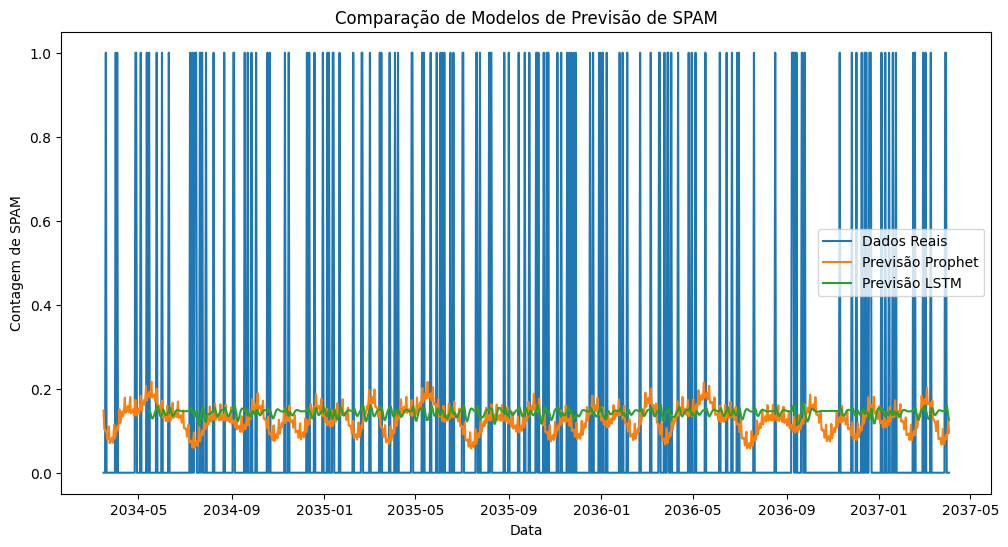

In [4]:

file_path = '/content/drive/MyDrive/modulo11/semana9/SpamDataset.csv'

!pip install -q sktime
!pip install -q prophet
!pip install -q tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Carregar o dataset e verificar colunas
df = pd.read_csv(file_path, encoding='latin1')
print(df.columns)

df.columns = ['Label', 'Message']

df['Date'] = pd.date_range(start='2022-01-01', periods=len(df), freq='D')

df['Spam'] = df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

daily_spam_count = df.groupby('Date').sum()['Spam']

df_series = daily_spam_count.reset_index().rename(columns={'Date': 'ds', 'Spam': 'y'})

train_size = int(len(df_series) * 0.8)
train = df_series.iloc[:train_size]
test = df_series.iloc[train_size:]

# Modelo Prophet
prophet_df = train.copy()
prophet_model = Prophet()
prophet_model.fit(prophet_df)

# Previsão com Prophet
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)
forecast = forecast.set_index('ds').loc[test['ds']]['yhat']

# Modelo LSTM
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['y']])
test_scaled = scaler.transform(test[['y']])

X_train, y_train = [], []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Construção e treinamento do modelo LSTM
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Preparação dos dados de teste para o LSTM
X_test = []
for i in range(60, len(test_scaled)):
    X_test.append(test_scaled[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions).flatten()

# Avaliação de Métricas
mse_prophet = mean_squared_error(test['y'], forecast)
mse_lstm = mean_squared_error(test['y'].iloc[60:], predictions)

print(f'MSE para o modelo Prophet: {mse_prophet}')
print(f'MSE para o modelo LSTM: {mse_lstm}')

# Plotagem
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Dados Reais')
plt.plot(test['ds'], forecast, label='Previsão Prophet')
plt.plot(test['ds'].iloc[60:], predictions, label='Previsão LSTM')
plt.xlabel('Data')
plt.ylabel('Contagem de SPAM')
plt.legend()
plt.title('Comparação de Modelos de Previsão de SPAM')
plt.show()


## Analisando o Gráfico:
Dados Reais (Azul): Como mencionado anteriormente, os dados são binários (0 ou 1), o que cria uma oscilação brusca entre esses valores. Isso não é ideal para LSTM ou Prophet, que funcionam melhor com valores contínuos.

Previsões (Prophet e LSTM): Ambos os modelos estão produzindo previsões suavizadas, como esperado. Prophet está capturando algumas tendências sazonais, enquanto LSTM também gera previsões suavizadas, mas não reflete bem as bruscas oscilações dos dados reais.

In [5]:
# Avaliação de Métricas
mse_prophet = mean_squared_error(test['y'], forecast)
mse_lstm = mean_squared_error(test['y'].iloc[60:], predictions)

# Adicionar MAE
mae_prophet = mean_absolute_error(test['y'], forecast)
mae_lstm = mean_absolute_error(test['y'].iloc[60:], predictions)

print(f'MSE para o modelo Prophet: {mse_prophet}')
print(f'MSE para o modelo LSTM: {mse_lstm}')
print(f'MAE para o modelo Prophet: {mae_prophet}')
print(f'MAE para o modelo LSTM: {mae_lstm}')


MSE para o modelo Prophet: 0.11485533724511814
MSE para o modelo LSTM: 0.11387817549667965
MAE para o modelo Prophet: 0.22495663687153444
MAE para o modelo LSTM: 0.23666809071296765


## Interpretação das Métricas:
MSE (Mean Squared Error): Fornece uma medida da magnitude dos erros, com uma penalização maior para erros grandes.

MAE (Mean Absolute Error): Fornece a média dos erros absolutos, o que pode ser mais adequado para seus dados binários.